In [6]:
import cv2
import matplotlib.pyplot as plt

fon1 = cv2.imread('materialy_feature_points/fontanna1.jpg')
fon1 = cv2.cvtColor(fon1, cv2.COLOR_BGR2GRAY)

fon2 = cv2.imread('materialy_feature_points/fontanna2.jpg')
fon2 = cv2.cvtColor(fon2, cv2.COLOR_BGR2GRAY)

In [7]:
import numpy as np
import scipy.ndimage.filters as filters

def harris(img, size=7, K=0.05):

    Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, size)
    Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, size)

    # I2x = cv2.Sobel(Ix, cv2.CV_32F, 1, 0, size)
    # I2y = cv2.Sobel(Iy, cv2.CV_32F, 0, 1, size)
    # Ixy = cv2.Sobel(Ix, cv2.CV_32F, 0, 1, size)

    I2x = Ix * Ix
    I2y = Iy * Iy
    Ixy = Ix * Iy

    I2xGaus = cv2.GaussianBlur(I2x, (size, size), 0)
    I2yGaus = cv2.GaussianBlur(I2y, (size, size), 0)
    IxyGaus = cv2.GaussianBlur(Ixy, (size, size), 0)

    H = np.zeros(img.shape).astype('float32')
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            det = I2xGaus[y, x] * I2yGaus[y, x] - IxyGaus[y, x] * IxyGaus[y, x]
            trace = I2xGaus[y, x] + I2yGaus[y, x]
            val = det - K * trace**2
            H[y, x] = val

    H = (H-np.min(H))/(np.max(H)-np.min(H))
    return H


def find_max(image, size, threshold): #size - maximum filter mask size
    data_max = filters.maximum_filter(image, size)
    maxima = (image == data_max)
    diff = image > threshold
    maxima[diff == 0] = 0
    return np.nonzero(maxima)

C:\Users\krzys\AppData\Local\Temp\ipykernel_10116\1624403902.py:34: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  data_max = filters.maximum_filter(image, size)


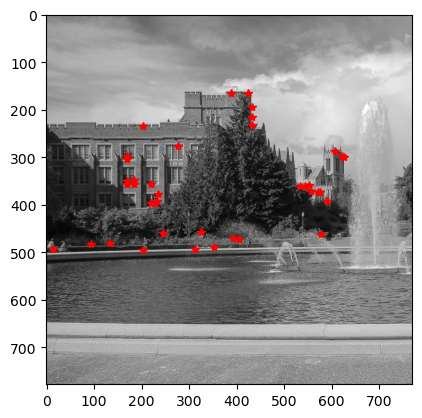

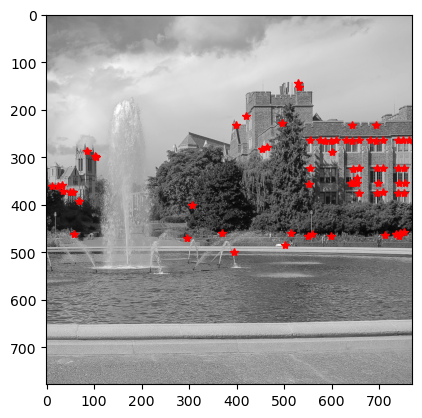

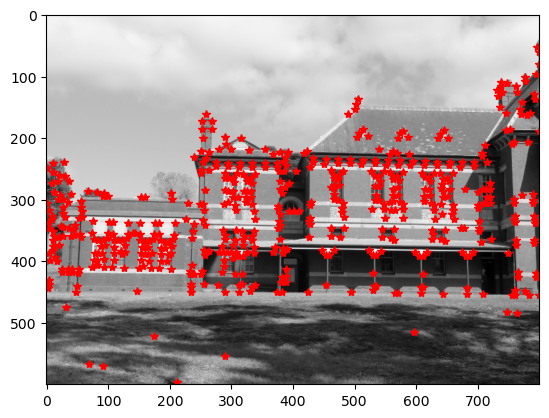

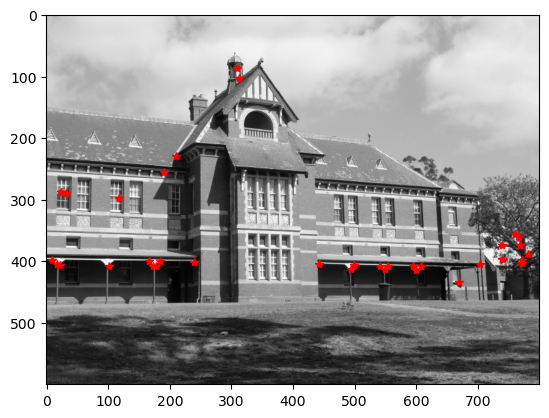

In [8]:
def draw_stars(img, pts):
    plt.figure()
    plt.imshow(img, 'gray')
    plt.plot(pts[1], pts[0], '*', color='r')
    plt.show()

bud1 = cv2.imread('materialy_feature_points/budynek1.jpg')
bud1 = cv2.cvtColor(bud1, cv2.COLOR_BGR2GRAY)
bud2 = cv2.imread('materialy_feature_points/budynek2.jpg')
bud2 = cv2.cvtColor(bud2, cv2.COLOR_BGR2GRAY)

size = 7

for img in [fon1, fon2, bud1, bud2]:
    H = harris(img, size)
    maxes = find_max(H, size, 0.5)
    draw_stars(img, maxes)

In [9]:
def descriptions(img, pts, size):
    Y, X = img.shape

    pts = list(filter(lambda pt: pt[0] >= size and pt[0] < Y - size 
                      and pt[1]>= size and pt[1] < X - size, zip(pts[0], pts[1])))
    
    descs = []
    for p in pts:
        desc = img[p[0]-size:p[0]+size+1, p[1]-size:p[1]+size+1]
        desc = desc.flatten()
        descs.append(desc)

    output = list(zip(pts, descs))
    return output

In [10]:
fon1 = cv2.imread('materialy_feature_points/fontanna1.jpg')
fon1 = cv2.cvtColor(fon1, cv2.COLOR_BGR2GRAY)
fon2 = cv2.imread('materialy_feature_points/fontanna2.jpg')
fon2 = cv2.cvtColor(fon2, cv2.COLOR_BGR2GRAY)

size = 7

H1 = harris(fon1, size)
maxes1 = find_max(H1, size, 0.5)
pts_descs1 = descriptions(fon1, maxes1, size)

H2 = harris(fon2, size)
maxes2 = find_max(H2, size, 0.5)
pts_descs2 = descriptions(fon2, maxes2, size)

C:\Users\krzys\AppData\Local\Temp\ipykernel_10116\1624403902.py:34: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  data_max = filters.maximum_filter(image, size)


In [11]:
def vector_diff(v1, v2):
    return sum(abs(v1 - v2))

def compare_descs(pts_descs1, pts_descs2, n):

    comparison = []
    for pts1, v1 in pts_descs1:

        min_val = float('inf')
        best_value = None
        for pts2, v2 in pts_descs2:
            diff = vector_diff(v1, v2)
            
            if diff < min_val:
                best_value = [pts1, pts2, diff]
                min_val = diff

        comparison.append(best_value)
    
    # comparison.sort(key=lambda x: x[2], reverse=True)
    comparison.sort(key=lambda x: x[2])
    comparison = comparison[:n]

    return comparison

c = compare_descs(pts_descs1, pts_descs2, 20)

In [12]:
from materialy_feature_points import pm

def matches_flow(path1, path2, size=15, n=20):
    path1 = 'materialy_feature_points/' + path1
    path2 = 'materialy_feature_points/' + path2

    img1 = cv2.imread(path1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(path2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    H1 = harris(img1, size)
    maxes1 = find_max(H1, size, 0.5)
    pts_descs1 = descriptions(img1, maxes1, size)

    H2 = harris(img2, size)
    maxes2 = find_max(H2, size, 0.5)
    pts_descs2 = descriptions(img2, maxes2, size)

    c = compare_descs(pts_descs1, pts_descs2, n)

    pm.plot_matches(img1, img2, c)

# matches_flow('fontanna1.jpg', 'fontanna2.jpg', 7)

In [13]:
# matches_flow('fontanna1.jpg', 'fontanna2.jpg')

In [14]:
# matches_flow('budynek1.jpg', 'budynek2.jpg')

In [15]:
# matches_flow('fontanna1.jpg', 'fontanna_pow.jpg')

In [16]:
# matches_flow('eiffel1.jpg', 'eiffel2.jpg')

In [17]:
def descriptions_modified(img, pts, size):
    Y, X = img.shape

    pts = list(filter(lambda pt: pt[0] >= size and pt[0] < Y - size 
                      and pt[1]>= size and pt[1] < X - size, zip(pts[0], pts[1])))
    
    descs = []
    for p in pts:
        desc = img[p[0]-size:p[0]+size+1, p[1]-size:p[1]+size+1]
        desc = desc.flatten()
        
        mean = np.mean(desc)
        std = np.std(desc)
        desc = (desc - mean) / std

        descs.append(desc)

    output = list(zip(pts, descs))
    return output

def matches_flow_modified(path1, path2, size=7, n=20):
    path1 = 'materialy_feature_points/' + path1
    path2 = 'materialy_feature_points/' + path2

    img1 = cv2.imread(path1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(path2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    H1 = harris(img1, size)
    maxes1 = find_max(H1, size, 0.5)
    pts_descs1 = descriptions(img1, maxes1, size)

    H2 = harris(img2, size)
    maxes2 = find_max(H2, size, 0.5)
    pts_descs2 = descriptions_modified(img2, maxes2, size)

    c = compare_descs(pts_descs1, pts_descs2, n)

    pm.plot_matches(img1, img2, c)

In [18]:
# matches_flow_modified('fontanna1.jpg', 'fontanna2.jpg')
# matches_flow_modified('budynek1.jpg', 'budynek2.jpg')
# matches_flow_modified('fontanna1.jpg', 'fontanna_pow.jpg')
# matches_flow_modified('eiffel1.jpg', 'eiffel2.jpg')

In [19]:
def corner_score(intensities, center_intensity, threshold, n=9):
    brighter = 0
    darker = 0
    
    for intensity in intensities:
        if intensity > center_intensity + threshold:
            brighter += 1
            if brighter >= n:
                return True
        elif intensity < center_intensity - threshold:
            darker += 1
            if darker >= n:
                return True
            
    return False

In [20]:
fon1 = cv2.imread('materialy_feature_points/fontanna1.jpg')
fon1 = cv2.cvtColor(fon1, cv2.COLOR_BGR2GRAY)
fon2 = cv2.imread('materialy_feature_points/fontanna2.jpg')
fon2 = cv2.cvtColor(fon2, cv2.COLOR_BGR2GRAY)

def fast(img, harr, threshold, r=3):
    points = []
    harr_values = []
    for y in range(r, img.shape[0] - r):
        for x in range(r, img.shape[1] - r):
            center_intensity = img[y, x]
            
            intensities = [
                img[y - 3, x], img[y - 3, x + 1], img[y - 2, x + 2], img[y - 1, x + 3],
                img[y, x + 3], img[y + 1, x + 3], img[y + 2, x + 2], img[y + 3, x + 1],
                img[y + 3, x], img[y + 3, x - 1], img[y + 2, x - 2], img[y + 1, x - 3],
                img[y, x - 3], img[y - 1, x - 3], img[y - 2, x - 2], img[y - 3, x - 1]
            ]

            if corner_score(intensities, center_intensity, threshold):
                points.append((y, x))
                harr_values.append(harr[y, x])
    return points, harr_values

  
def fast_points(img, threshold=40, N=200):

    harr = harris(img)

    size = 7
    r = size // 2

    points, harr_values = fast(img, harr, threshold, r)

    points_harr = list(zip(points, harr_values))
    points_harr.sort(key=lambda x: x[1], reverse=True)
    points_harr = points_harr[:N]

    # output = {}
    # for p, h in points_harr:
    #     output[p] = h

    output = {key: value for key, value in points_harr}

    # output = dict(zip(points, harr_values))
    
    print(f"FAST Algorithm has found {len(output)} characteristic points")
    return output


# o = fast_points(fon1)

In [21]:
def non_max(img, points: dict):

    values_to_remove = []
    for p, h in points.items():
        if (p, h) in values_to_remove:
            continue
        
        y, x = p
        values = []
        for i in range(y-1, y+2):
            for j in range(x-1, x+2):
                if i<0 or j<0 or i>img.shape[0]-1 or j>img.shape[1]-1:
                    continue
                if (i, j) in points:
                    values.append(((i, j), points[(i, j)]))

        if len(values) > 1:
            values.sort(key=lambda x: x[1])
            for v in values[:-1]:
                if v not in values_to_remove:
                    values_to_remove.append(v)
    

    for v in values_to_remove:
        points.pop(v[0])
    print(f"After non-max suppresion: {len(points)} points left")
    return points

# points_clear = non_max(fon1, o)      


In [22]:
def filter_out_non_surr(img, points_clear, size=31):
    Y, X = img.shape
    pts = list(filter(lambda pt: pt[0][0] >= size and pt[0][0] < Y - size 
                    and pt[0][1]>= size and pt[0][1] < X - size, list(zip(points_clear.keys(), points_clear.values()))))
    
    print(f"Points within {size} to border: {len(pts)}")
    return pts

# points_filtered = filter_out_non_surr(fon1, points_clear)

In [23]:
# n=30
# points_filtered.sort(key=lambda x: x[1], reverse=True)
# points_best = points_filtered[:n]

In [24]:
def intensity_centroid(img, points_best, r=9):

    C_out = []
    theta_out = []
    for p, _ in points_best:
        y, x = p
        m00 = 0
        m01 = 0
        m10 = 0
        for i in range(y-r, y+r+1):
            for j in range(x-r, x+r+1):
                dy = y - i
                dx = x - j
                dst = dx*dx + dy*dy
                if dst <= r*r:
                    m00 += img[i, j]
                    m01 += dy * img[i, j]
                    m10 += dx * img[i, j]
        C = (m10/m00, m01/m00)
        theta = np.arctan2(m01, m10)
        C_out.append(C)
        theta_out.append(theta)
        
    return C_out, theta_out

# C, theta = intensity_centroid(fon1, points_best)

In [25]:
def brief_rand(ctx, n=256):

    # output = 0
    output = []
    for i in range(1, n):
        ui = (np.random.randint(0, ctx.shape[0]-1), np.random.randint(0, ctx.shape[1]-1))
        vi = (np.random.randint(0, ctx.shape[0]-1), np.random.randint(0, ctx.shape[1]-1))
        while ui == vi:
            vi = (np.random.randint(0, ctx.shape[0]-1), np.random.randint(0, ctx.shape[1]-1))

        if ctx[ui] < ctx[vi]:
            output.append(1)
        else:
            output.append(0)

        # if ctx[ui] < ctx[vi]:
        #     output += 2**(i-1)
    return output

def brief_defined(ctx, theta):

    score = []
    with open('materialy_feature_points/orb_descriptor_positions.txt', 'r') as f:
        for line in f:
            vals = line.split(' ')
            vals = [float(x) for x in vals]

            vals = [x + 15 for x in vals] #rescale form -15, 15 to 0, 30

            ui = vals[:2]
            vi = vals[2:]

            ui[0] = int(np.cos(theta)*ui[0] + np.sin(theta)*ui[1])
            ui[1] = int(np.sin(theta)*ui[1] + np.cos(theta)*ui[0])

            vi[0] = int(np.cos(theta)*vi[0] + np.sin(theta)*vi[1])
            vi[1] = int(np.sin(theta)*vi[1] + np.cos(theta)*vi[0])

            ui = tuple(ui)
            vi = tuple(vi)

            if ctx[ui] < ctx[vi]:
                score.append(1)
            else:
                score.append(0)

    return score

         

def brief(img, pts, theta, size=31):

    scores = []
    pts = [x[0] for x in pts] #remove values (only y, x left)
    for i, p in enumerate(pts):

        y, x = p
        # y, x = int(y), int(x)

        th = theta[i]

        ctx = img[y-size:y+size+1, x-size:x+size+1]
        ctxGaus = cv2.GaussianBlur(ctx, (5, 5), 0)
        # brief_score = brief_rand(ctxGaus)
        brief_score = brief_defined(ctxGaus, th)
        scores.append(brief_score)

    return scores

# final_scores = brief(fon1, points_best, theta)

In [43]:
from materialy_feature_points import pm

def orb(img, threshold=40, n=30):
    points = fast_points(img, threshold)
    points_clear = non_max(img, points)
    points_filtered = filter_out_non_surr(img, points_clear)
    
    points_filtered.sort(key=lambda x: x[1], reverse=True)
    points_best = points_filtered[:n]
    C, theta = intensity_centroid(img, points_best)
    scores = brief(img, points_best, theta)
    points_best = [p[0] for p in points_best]

    return scores, points_best

# scores = orb(fon1)
SCALER = 1.5

def pyramid(img, max_scale):
    images = [img]
    for k in range(1, max_scale):
        images.append(cv2.resize(images[k-1], (0, 0), fx=1/SCALER, fy=1/SCALER))
    return images

def two_img_points(img1, img2):
    scores1, pts1 = orb(img1)
    scores2, pts2 = orb(img2)

    comparison = compare_scores_orb(scores1, scores2, pts1, pts2)
    pm.plot_matches(img1, img2, comparison)

def mutli_scale_orb(img1, img2, max_scale=3):
    img1_list = pyramid(img1, max_scale)
    img2_list = pyramid(img2, max_scale)

    pts1_list = []
    pts2_list = []

    scores1_list = []
    scores2_list = []

    img1_orig = img1.copy()
    img2_orig = img2.copy()

    for scale in range(max_scale-1, -1, -1):
        img1 = img1_list[scale]
        img2 = img2_list[scale]

        scores1, pts1 = orb(img1)
        scores2, pts2 = orb(img2)

        pts1_map = np.zeros(img1.shape)
        pts2_map = np.zeros(img2.shape)

        pts1_map[tuple(np.transpose(pts1))] = 1
        pts2_map[tuple(np.transpose(pts2))] = 1

        pts1_map = cv2.resize(pts1_map, (img1_orig.shape[1], img1_orig.shape[0]), interpolation=cv2.INTER_LINEAR)
        pts2_map = cv2.resize(pts2_map, (img2_orig.shape[1], img2_orig.shape[0]), interpolation=cv2.INTER_LINEAR)

        r1, c1, = np.nonzero(pts1_map)
        r2, c2, = np.nonzero(pts2_map)

        pts1 = [(i, j) for i, j in zip(r1, c1)]
        pts2 = [(i, j) for i, j in zip(r2, c2)]

        pts1_list += pts1
        pts2_list += pts2

        scores1_list += scores1
        scores2_list += scores2

    comparison = compare_scores_orb(scores1_list, scores2_list, pts1_list, pts2_list)
    pm.plot_matches(img1, img2, comparison)
    

def hamming(arr1, arr2):

    val = 0
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            val += 1
    return val

def compare_scores_orb(scores1, scores2, pts1, pts2, n=30):

    comparison = []

    for p1, s1 in zip(pts1, scores1):
        
        min_val = float('inf')
        best_value = None
        for p2, s2 in zip(pts2, scores2):
            diff = hamming(s1, s2)

            if diff < min_val:
                best_value = [p1, p2, diff]
                min_val = diff

        comparison.append(best_value)
    
    comparison.sort(key=lambda x: x[2])
    comparison = comparison[:n]

    return comparison
    

FAST Algorithm has found 200 characteristic points
After non-max suppresion: 68 points left
Points within 31 to border: 64
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 60 points left
Points within 31 to border: 40
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 60 points left
Points within 31 to border: 60
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 52 points left
Points within 31 to border: 37
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 56 points left
Points within 31 to border: 55
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 63 points left
Points within 31 to border: 51


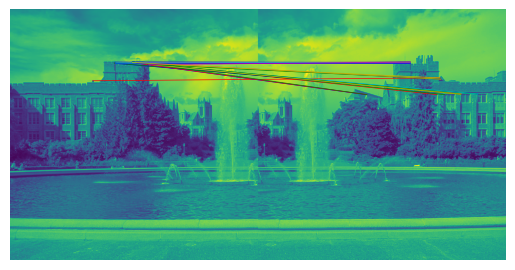

In [44]:
# two_img_points(fon1, fon2)
mutli_scale_orb(fon1, fon2, 3)

In [45]:
def orb_full_flow(path1, path2, max_scale=3):
    path1 = 'materialy_feature_points/' + path1
    path2 = 'materialy_feature_points/' + path2

    img1 = cv2.imread(path1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(path2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # two_img_points(img1, img2)
    mutli_scale_orb(img1, img2, max_scale)

FAST Algorithm has found 200 characteristic points
After non-max suppresion: 26 points left
Points within 31 to border: 23
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 30 points left
Points within 31 to border: 23
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 44 points left
Points within 31 to border: 44
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 32 points left
Points within 31 to border: 23
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 66 points left
Points within 31 to border: 65
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 45 points left
Points within 31 to border: 37


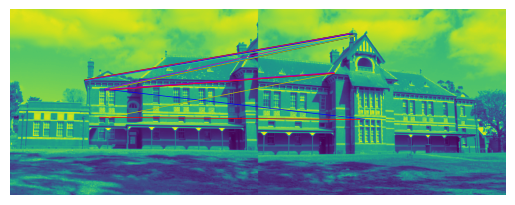

In [46]:
orb_full_flow('budynek1.jpg', 'budynek2.jpg')

FAST Algorithm has found 200 characteristic points
After non-max suppresion: 41 points left
Points within 31 to border: 23
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 36 points left
Points within 31 to border: 28
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 38 points left
Points within 31 to border: 26
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 40 points left
Points within 31 to border: 40
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 42 points left
Points within 31 to border: 34
FAST Algorithm has found 200 characteristic points
After non-max suppresion: 68 points left
Points within 31 to border: 68


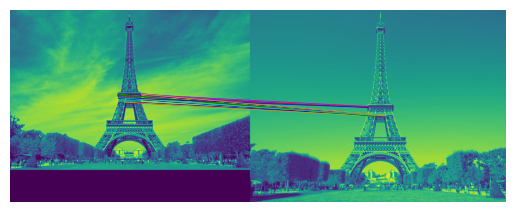

In [47]:
orb_full_flow('eiffel1.jpg', 'eiffel2.jpg')

In [ ]:
im1 = cv2.imread('materialy_feature_points/left_panorama.jpg')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.imread('materialy_feature_points/right_panorama.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints1 = sift.detect(im1, None)
keypoints2 = sift.detect(im2, None)

out1 = cv2.drawKeypoints(im1, keypoints1, 0, (0, 0, 255),
                         flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
out2 = cv2.drawKeypoints(im2, keypoints2, 0, (0, 0, 255),
                         flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(out1)
ax[1].imshow(out2)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the two images
image1 = cv2.imread('materialy_feature_points/left_panorama.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('materialy_feature_points/right_panorama.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Initialize the matcher
# matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
matcher = cv2.BFMatcher(cv2.NORM_L2) 

# Match descriptors using KNN matcher
knn_matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to obtain good matches
good_matches = []
for m, n in knn_matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)

keypoints1 = np.float32([kp.pt for kp in keypoints1])
keypoints2 = np.float32([kp.pt for kp in keypoints2])

# Extract keypoints from good matches
# src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
src_pts = np.float32([keypoints1[m.queryIdx] for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx] for m in good_matches])

# Use cv2.findHomography() to find the perspective transformation
homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Apply the perspective transformation to warp image1 onto the same perspective as image2
# result = cv2.warpPerspective(image1, homography_matrix, (image2.shape[1], image2.shape[0]))
result = cv2.warpPerspective(image1, homography_matrix, (image2.shape[1] + image1.shape[1], image2.shape[0]+image1.shape[0]))

result[0:image2.shape[0], 0:image2.shape[1]] = image2

# result = cv2.resize(result, (image1.shape[0], image1.shape[1]), cv2.INTER_LINEAR)

# Display the warped image
# cv2.imshow('Warped Image', warped_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
f, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image1, 'gray')
ax[0].set_title('image left')
ax[1].imshow(image2, 'gray')
ax[1].set_title('image right')
ax[2].imshow(result, 'gray')
ax[2].set_title('image warped')
plt.show()
